# Codestates Project 2 - Data Science Field Salary

질문. 나와 동기들의 10년뒤 연봉은 얼마나 될까?

Dataset : data_0_Levels_Fyi_Salary_Data.csv  
From : https://www.kaggle.com/datasets/jackogozaly/data-science-and-stem-salaries  

Features
- timestamp : 기록시간인듯?
- company : 회사 1632개
- level : 직급인듯? (약 3000)
- title : 하는일
- totalyearlycompensation : 총급여
- location : 위치
- years of experience : 경력
- years at company : 근속연수
- tag : 하는일
- basesalary : 기본급여
- stock grant value : 스톡옵션
- bonus : 보너스
- gender : 성별
- cityid : 도시번호?
- dmaid : media market, 지역분할 방식인듯?
- degree : 학위
- race : 인종  
       [nan, 'White', 'Asian', 'Black', 'Two Or More', 'Hispanic']
- education : 교육  
       [nan, 'PhD', "Master's Degree", "Bachelor's Degree", 'Some College', 'Highschool']

Dataset : data_1_india_data_field.csv  
From : https://www.kaggle.com/datasets/jaiganeshnagidi/data-scientist-salary

Dataset : data_2_cleaned_2021.csv  
From : https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor  

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import category_encoders

from lightgbm import LGBMRegressor

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 30)


In [96]:
df_0 = pd.read_csv("data_0_Levels_Fyi_Salary_Data.csv")
print(df_0.shape)
df_0.head(5).T

(62642, 29)


,0,1,2,3,4
timestamp,6/7/2017 11:33:27,6/10/2017 17:11:29,6/11/2017 14:53:57,6/17/2017 0:23:14,6/20/2017 10:58:51
company,Oracle,eBay,Amazon,Apple,Microsoft
level,L3,SE 2,L7,M1,60
title,Product Manager,Software Engineer,Product Manager,Software Engineering Manager,Software Engineer
totalyearlycompensation,127000,100000,310000,372000,157000
location,"Redwood City, CA","San Francisco, CA","Seattle, WA","Sunnyvale, CA","Mountain View, CA"
yearsofexperience,1.5,5.0,8.0,7.0,5.0
yearsatcompany,1.5,3.0,0.0,5.0,3.0
tag,NaN,NaN,NaN,NaN,NaN
basesalary,107000.0,0.0,155000.0,157000.0,0.0


In [97]:
# drop unsued
df_0 = df_0.drop(["otherdetails", "dmaid", "level","rowNumber"], axis=1)

# change columns name
df_0 = df_0.rename(
    columns = {"totalyearlycompensation":"annual_income",
               "yearsofexperience":"years_of_experience"},
    )

# set target
target = "annual_income"

<AxesSubplot:>

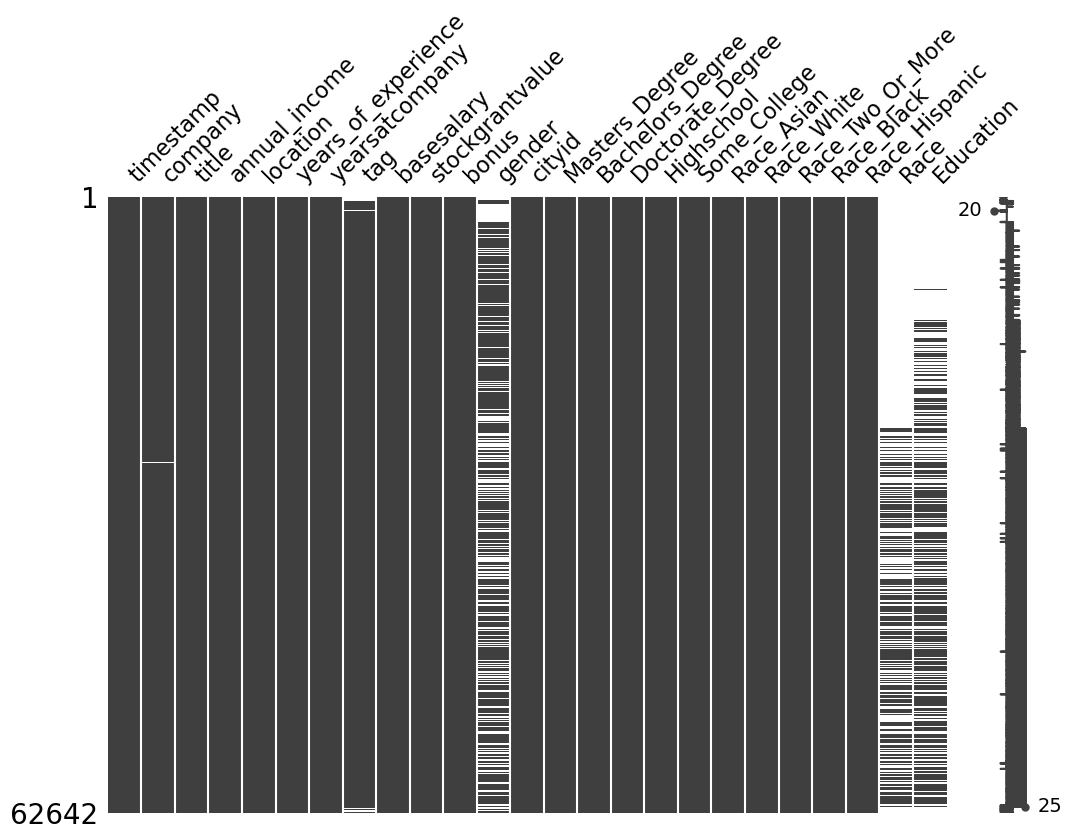

In [98]:
msno.matrix(df_0, figsize=(12, 8))

In [99]:
# 결측치 처리
df_0.isna().sum()
# company : drop
df_0_cln = df_0.dropna(subset="company")

# tag, gender : nan -> no_answer
nan_cols = ["tag", "gender", "Race", "Education"]
df_0_cln[nan_cols] = df_0_cln[nan_cols].fillna("no_answer")

# 
df_0_cln.isna().sum()

C:\Users\TESB\AppData\Local\Temp\ipykernel_14060\3774717547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_cln[nan_cols] = df_0_cln[nan_cols].fillna("no_answer")


timestamp              0
company                0
title                  0
annual_income          0
location               0
years_of_experience    0
yearsatcompany         0
tag                    0
basesalary             0
stockgrantvalue        0
bonus                  0
gender                 0
cityid                 0
Masters_Degree         0
Bachelors_Degree       0
Doctorate_Degree       0
Highschool             0
Some_College           0
Race_Asian             0
Race_White             0
Race_Two_Or_More       0
Race_Black             0
Race_Hispanic          0
Race                   0
Education              0
dtype: int64

In [100]:
# 이상치 처리
# df_0_cln[df_0_cln.gender == 'Title: Senior Software Engineer'].T
df_0_cln.at[11010,"gender"] = "no_answer"
df_0_cln.gender.unique()

array(['no_answer', 'Male', 'Female', 'Other'], dtype=object)

In [101]:
# 실험실

# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data")][["tag","title"]] # 1941
# df_0_cln.tag.str.contains("(?i)data")
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)iphone")][["tag","title"]] # ios
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)android")][["tag","title"]] # ios
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data engineer")][["tag","title"]] # 67

# temp = df_0_cln[(df_0_cln.tag.str.contains("(?i)anal")) & (df_0_cln.title == "Data Scientist")] # 187
# temp = df_0_cln[df_0_cln.tag.str.contains("(?i)data science")][["tag","title"]] # 25



# temp = df_0_cln.location.str.split(pat=", ",n=2,expand=True)
# countries = []
# for i in temp.index:
#     country = temp.at[i,2]
#     countries.append(("U.S." if pd.isna(country) else country))
# countries

# for i in temp.index:
#     if pd.isna(temp.at[i,3]) :
#         countries.append("U.S.")
#     else:
#         countries.append(temp[i,3])

# [ "U.S." if False else temp[2] ]

# temp = temp.str.split(pat=" ",n=1, expand=True)
# df_0_cln.location

# df.info()
    
# temp
# temp.tag.unique()

In [102]:
# feature engineering
def feature_engineering(df):

    # 날짜 분리
    df.timestamp = pd.to_datetime(df.timestamp)
    df["year"] = df["timestamp"].dt.year
    df["date"] = df["timestamp"].dt.date.astype(str)
    df["date"] = df["date"].str.replace("-","").astype(int)

    # 직무 관련 특성 생성
    ml = df.tag.str.contains("(?i)ml")
    machine = df.tag.str.contains("(?i)machine") & ~df.tag.str.contains("Machine Vision")
    data_woker = df.title == "Data Scientist"
    software_engineer = df.title == "Software Engineer"
    software_enginerr_mng = df.title == "Software Engineering Manager"
    abt_data = df.tag.str.contains("(?i)data")
    data_scientist = ((df.tag.str.contains("(?i)data science")) | (df.tag.str.contains("(?i)data scientist")))

    df["developer"]       = data_woker | software_engineer | software_enginerr_mng
    df["data_woker"]      = data_woker
    df["machin_learning"] = ml | machine
    df["ai"]              = df.tag.str.contains("(?i)ai") & ~df.tag.str.contains("(?i)ai[a-z]")
    df["data_analytics"]  = df.tag.str.contains("(?i)anal") & data_woker
    df["data_scientist"]  = data_scientist
    df["data_engineer"]   = df.tag.str.contains("(?i)data engineer")
    df["data_area"]       = (
        (abt_data & data_woker)
        | (abt_data & software_engineer)
        | (abt_data & software_enginerr_mng)
        | (df["machin_learning"])
        | (df["ai"])
        | (df["data_analytics"])
        | (df["data_scientist"])
        | (df["data_engineer"])
    )

    df["ios"] = df.tag.str.contains("(?i)ios")
    df["android"] = df.tag.str.contains("(?i)android")

    # 지역 데이터 분리
    temp = df.location.str.split(pat=", ", n=2, expand=True)
    df["city"] = temp[0]
    df["state"] = temp[1]
    countries = []
    for i in temp.index:
        country = temp.at[i, 2]
        countries.append(("U.S." if pd.isna(country) else country))
    df["country"] = countries

    # Drop columns
    drop_cols = [
        "timestamp",
        "Masters_Degree",
        "Bachelors_Degree",
        "Doctorate_Degree",
        "Highschool",
        "Some_College",
        "Race",
        "location",
    ]
    df = df.drop(drop_cols, axis=1)

    return df


df_0_eng = feature_engineering(df_0_cln.copy())


In [103]:
# 표본이 많은 상위 20개국 + 한국

countries = df_0_eng["country"].value_counts()[:15].index.to_list()
countries.append("Korea, South")
countries.append("Japan")
countries.append("China")
countries

df_0_flt = df_0_eng[df_0_eng["country"].isin(countries)]


In [104]:
def column_avg(df, col, orient="v"):
    temp = df[[col,target]]
    temp = temp.groupby(col).agg(np.mean)
    temp = temp.reset_index(col)
    temp = temp.sort_values(target,ascending=False)
    # print(temp.annual_income.values.round(0))
    plt.close("all")
    plt.figure(figsize=(8,8))
    if(orient == "v"):
        sns.barplot(data=temp,x=col,y=target, orient=orient)
    else :
        sns.barplot(data=temp,x=target,y=col, orient=orient)

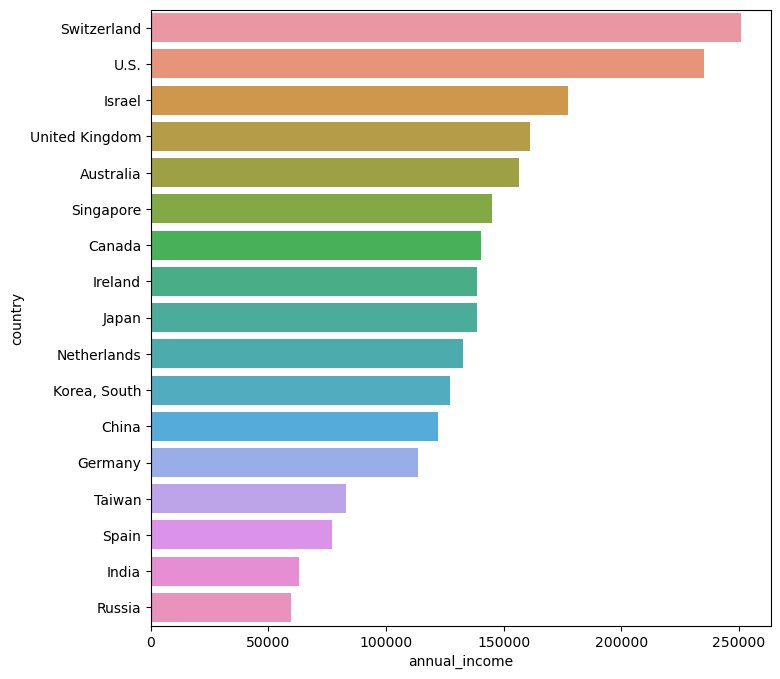

In [105]:
column_avg(df=df_0_flt, col="country",orient="h")

In [106]:
# encoding
# ordinal
def encodings(df):
    
    degrees = [
            "no_answer", 
            "Highschool",
            "Some College",
            "Bachelor's Degree",
            "Master's Degree",
            "PhD",
        ]
    edu_enc = OrdinalEncoder(categories=[degrees])
    df[["Education"]] = edu_enc.fit_transform(X=df[["Education"]]).astype(int)
    
    
    label_cols = [
        "company",
        "title",
        "gender",
        "country",
        "state",
        "city",
    ]
    ord_enc = category_encoders.OrdinalEncoder(cols=label_cols)
    df[label_cols] = ord_enc.fit_transform(df[label_cols])

    return df

df_0_enc = encodings(df_0_flt.copy())


In [107]:
df_0_enc.head().T
# df_0_eng.loc[61987]

,0,1,2,3,4
company,1,2,3,4,5
title,1,2,1,3,2
annual_income,127000,100000,310000,372000,157000
years_of_experience,1.5,5.0,8.0,7.0,5.0
yearsatcompany,1.5,3.0,0.0,5.0,3.0
...,...,...,...,...,...
ios,False,False,False,False,False
android,False,False,False,False,False
city,1,2,3,4,5
state,1,1,2,1,1


<AxesSubplot:xlabel='annual_income', ylabel='Count'>

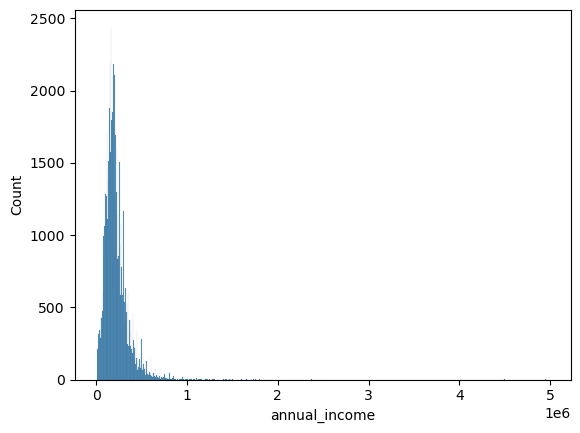

In [108]:
# df_0_enc["yearsofexperience"].describe()
plt.close("all")
sns.histplot(df_0_enc[target])
# plt.hist(df_0_cln["yearsofexperience"])
# xticks = range(0,70)

# plt.xticks(xticks)

In [115]:
df_0_enc.columns

Index(['company', 'title', 'annual_income', 'years_of_experience',
       'yearsatcompany', 'tag', 'basesalary', 'stockgrantvalue', 'bonus',
       'gender', 'cityid', 'Race_Asian', 'Race_White', 'Race_Two_Or_More',
       'Race_Black', 'Race_Hispanic', 'Education', 'year', 'date', 'developer',
       'data_woker', 'machin_learning', 'ai', 'data_analytics',
       'data_scientist', 'data_engineer', 'data_area', 'ios', 'android',
       'city', 'state', 'country'],
      dtype='object')

In [116]:
using_features = [
    'company', 
    # 'title', 
    'annual_income', 
    'years_of_experience',
    # 'yearsatcompany', 
    # 'tag', 
    # 'basesalary', 
    # 'stockgrantvalue', 
    # 'bonus',
    'gender', 
    'cityid', 
    'Race_Asian', 
    'Race_White', 
    'Race_Two_Or_More',
    'Race_Black', 
    'Race_Hispanic', 
    'Education', 
    'year', 
    # 'date', 
    'developer',
    'data_woker', 
    'machin_learning', 
    'ai', 
    'data_analytics',
    'data_scientist', 
    'data_engineer', 
    'data_area', 
    # 'ios', 
    # 'android',
    # 'city', 
    # 'state', 
    'country']

df_0_final = df_0_enc[using_features]
df_0_final.head().T

,0,1,2,3,4
company,1,2,3,4,5
annual_income,127000,100000,310000,372000,157000
years_of_experience,1.5,5.0,8.0,7.0,5.0
gender,1,1,1,1,1
cityid,7392,7419,11527,7472,7322
Race_Asian,0,0,0,0,0
Race_White,0,0,0,0,0
Race_Two_Or_More,0,0,0,0,0
Race_Black,0,0,0,0,0
Race_Hispanic,0,0,0,0,0


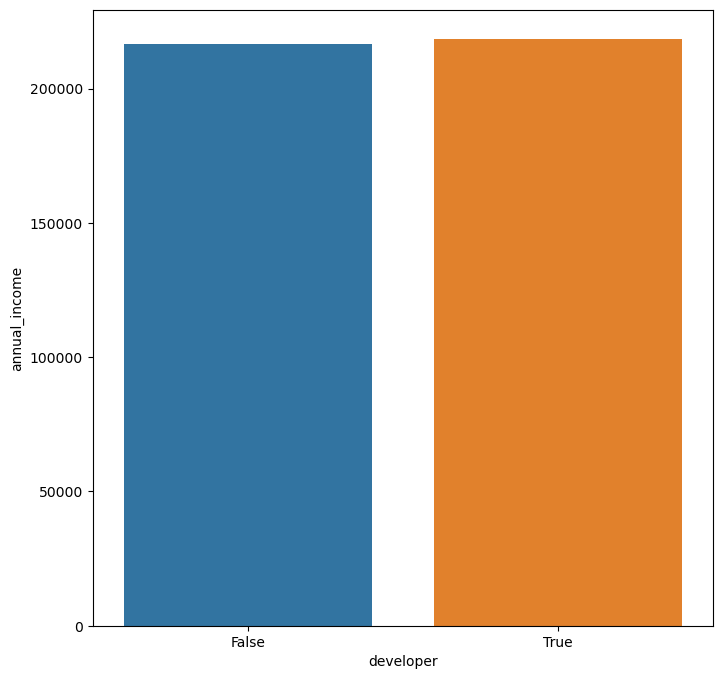

In [119]:
column_avg(df_0_final,"developer")

# temp = df_0_final[["developer",target]]
# temp = temp.groupby("developer").agg(np.mean)
# temp = temp.reset_index("developer")
# print(temp.annual_income.values.round(0))
# sns.barplot(data=temp,x="developer",y=target)

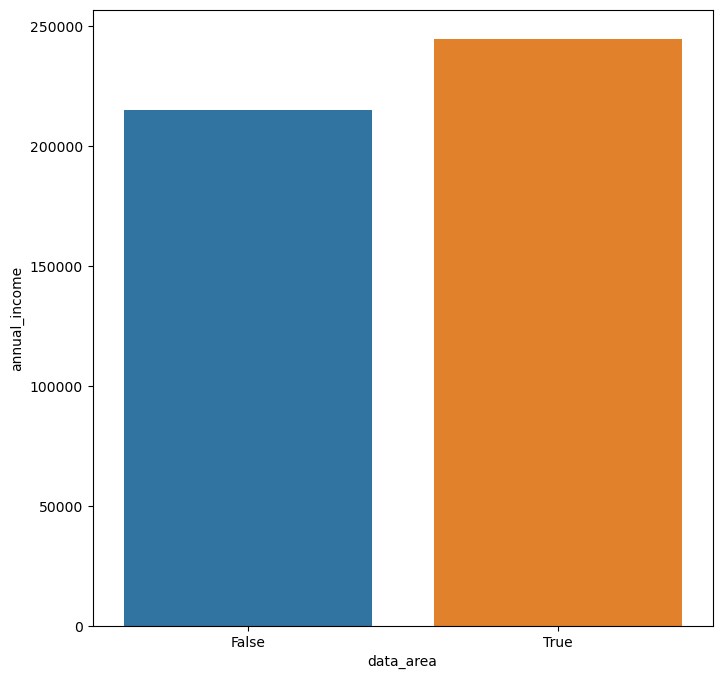

In [120]:
column_avg(df_0_final, "data_area")
# developer = df_0_final[df_0_final.developer == True]
# temp = developer.groupby("data_area").agg(np.mean)
# temp = temp.reset_index("data_area")
# print(temp.annual_income.values.round(0))
# sns.barplot(data=temp,x="data_area",y=target)

In [121]:
# 데이터 분야 평균 연봉
data_engineer = df_0_final[df_0_final.data_engineer == True][target]
print("data_engineer : ", data_engineer.shape[0], np.round(data_engineer.mean(),0))
data_analytics = df_0_final[df_0_final.data_analytics == True][target]
print("data_analytics : ",data_analytics.shape[0], np.round(data_analytics.mean(),0))
data_scientist = df_0_final[df_0_final.data_scientist == True][target]
print("data_scientist : ", data_scientist.shape[0], np.round(data_scientist.mean(),0))
ai = df_0_final[df_0_final.ai == True][target]
print("ai : ", ai.shape[0], np.round(ai.mean(),0))
machine_learning = df_0_final[df_0_final.machin_learning == True][target]
print("machine_learning", machine_learning.shape[0], np.round(machine_learning.mean(),0))

# np.round(data_engineer,0), np.round(data_analytics,0), np.round(data_scientist,0), np.round(ai,0), np.round(machine_learning,0)

data_engineer :  67 208910.0
data_analytics :  188 197505.0
data_scientist :  122 206311.0
ai :  4281 265170.0
machine_learning 4410 262839.0


In [117]:

# X = df_0_final.drop(target, axis=1)
# y = df_0_final[target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train, test = train_test_split(df_0_final, test_size=0.2, random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_test, y_test = test.drop(target, axis=1), test[target]

In [118]:
train.shape, test.shape

((49446, 21), (12362, 21))

In [122]:
# Linear Regressor


In [123]:
# light GBM
lgbmr = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
)
lgbmr.fit(X_train, y_train)

LGBMRegressor(random_state=42)

In [124]:
y_pred = lgbmr.predict(X_test)
r2 = r2_score(y_true=y_test,y_pred=y_pred)
r2

0.571055936509711

In [50]:
df = pd.read_csv("data_1_india_data_field.csv")
print(df.shape)
df.head(5).T

(19802, 9)


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
experience,5-7 yrs,10-17 yrs,5-9 yrs,7-10 yrs,1-3 yrs
job_description,Exp: Minimum 5 years;Good understanding of IOC...,He should have handled a team of atleast 5-6 d...,Must be an effective communicator (written & s...,7 - 10 years of overall experience in data e...,Chartered Accountancy degree or MBA in Finance...
job_desig,Senior Exploit and Vulnerability Researcher,Head SCM,Deputy Manager - Talent Management & Leadershi...,Associate Manager Data Engineering,TS- GSA- Senior Analyst
job_type,NaN,NaN,Analytics,Analytics,NaN
key_skills,"team skills, communication skills, analytical ...","ppc, logistics, inventory management, supply c...","HR Analytics, Employee Engagement, Training, S...","SQL, Javascript, Automation, Python, Ruby, Ana...","accounting, finance, cash flow, financial plan..."
location,Delhi NCR(Vikas Puri),Sonepat,Delhi NCR,Bengaluru,Gurgaon
salary,6to10,10to15,15to25,10to15,3to6
company_name_encoded,3687,458,4195,313,1305
